In [1]:
import numpy as np
import pandas as pd

In [2]:
def split_train_test(file, ratio=0.2, target='target', save=True):
    dataset = pd.read_csv(file, sep='\t', header=0)
    target_partition = dataset[dataset[target]==1]
    non_target_partition = dataset[dataset[target]==0]
    
    def split_df(df, ratio):
        small = df.sample(frac=ratio)
        large = df[~df.index.isin(small.index)]
        return small, large
    
    small_target, large_target = split_df(target_partition,ratio)
    small_non_target, large_non_target = split_df(non_target_partition,ratio)
    
    small = pd.concat([small_target, small_non_target], ignore_index=True)
    large = pd.concat([large_target, large_non_target], ignore_index=True)
    small = small.reindex(np.random.permutation(small.index))
    large = large.reindex(np.random.permutation(large.index))
    
    if save:
        small.to_csv(file + ".golden", sep="\t",index=False)
        large.to_csv(file + ".training", sep="\t",index=False)
    
    return small, large

# split_train_test("/Users/blhuang/workspace/DAR/es_drip_201809.tsv")


In [3]:
# Defect train dataset
# s3://intech-search-dev-dar/training-data/es/*

train_df_path = "/Users/blhuang/workspace/DAR/es_drip_201809.tsv.training"
# test_df_path = '/Users/blhuang/workspace/DAR/es_drip_201809_test.tsv'
test_df_path = "/Users/blhuang/workspace/DAR/es_drip_201809.tsv.golden"


#output path
pmml_file='es_defect.pmml'

In [4]:

features = ["quer_numdigterms","maxmatchdigterms_title_q","query_asin_coec","query_asin_poep",
            "query_asin_aoea","fwp_noisyor","phrasedoc_score","quer_specificity","quer_max_phrasedoc",
            "cvrg_simpletitle","field_weighted_proximity","exct_simple_title","pxsc_title","pxsc_itemtypekeyword",
            "quer_length","quer_mean_phrasedoc","non_subjectkeywords_match","length_normalized_termdoc",
            "pxsc_producttypename","cvrg_title","non_description_match","pxsc_subject","decent_match",
            "non_merchant_match","non_bullet_match","quer_count_phrasedoc","non_stylekeywords_match",
            "non_external_match","cvrg_itemtypekeyword","qba_log_cshare","nummatchbigrams_title_q",
            "phrasedoc_only_match","non_generickeywords_match","pxsc_simpletitle","maxmatchterms_title_q",
            "maxmatchterms_simpletitle_q","restricted_match","qba_score_collapsed","has_pte","qu_match_brand",
            "query_asin_price_zscore","price_fma","quer_wt_avg_price_v2","query_entity_price_ratio",
            "normalized_query_asin_ent"
     ]
features = [
'quer_numdigterms',
'query_asin_coec',
'query_asin_poep',
'query_asin_aoea',
'fwp_noisyor',
'phrasedoc_score',
'quer_specificity',
'quer_max_phrasedoc',
'field_weighted_proximity',
'pxsc_title',
'quer_length',
'quer_mean_phrasedoc',
'length_normalized_termdoc',
'pxsc_subject',
'quer_count_phrasedoc',
# 'cvrg_itemtypekeyword',
'qba_log_cshare',
# 'nummatchbigrams_title_q',
'pxsc_simpletitle',
# 'restricted_match',
# 'qba_score_collapsed',
'query_asin_price_zscore',
'quer_wt_avg_price_v2',
'query_entity_price_ratio',
# 'normalized_query_asin_ent'
]

target = 'target'


In [5]:
# target=1 when record is product_type_wrong, else target=0

X_y_train = pd.read_csv(train_df_path, sep='\t', header=0)
X_y_test = pd.read_csv(test_df_path, sep='\t', header=0)


In [6]:
# es_judgment_path = "/Users/blhuang/workspace/DAR/es_judgment_v1_qs_tagged.tsv"
# (test, train) = split_train_test(es_judgment_path, 0.2, "target", False)

# X_y_train = pd.concat([train, X_y_train], ignore_index=True, sort=True)
# X_y_test = pd.concat([test, X_y_test], ignore_index=True, sort=True)


In [7]:
# Filter out records docid is nan
# Fill with 0 for other fields is nan

X_y_train = X_y_train[X_y_train.docid.notnull()]
X_y_test = X_y_test[X_y_test.docid.notnull()]

X_y_train = X_y_train.fillna(0)
X_y_test = X_y_test.fillna(0)


In [8]:
# Split to X and y

X_train = X_y_train[features]
y_train = X_y_train[target]
X_test = X_y_test[features]
y_test = X_y_test[target]

In [9]:
import lightgbm
print(lightgbm.__version__)

from lightgbm import LGBMClassifier,LGBMModel
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, confusion_matrix, average_precision_score

import sklearn
#default initial parameters for feature selection
lgb_model = LGBMClassifier(boosting_type='gbdt',
                      objective='binary',
                      max_depth=6,
                      learning_rate=0.2,
                      n_estimators=200,
                      min_child_samples=50,
                     silent=False)

2.0.1


In [10]:
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV

# Initialize CV and evaluation objects
kfold = KFold(n_splits=2)

feature_selector = RFECV(lgb_model, cv=kfold, verbose=1, scoring='average_precision')
feature_selector.fit(X_train, y_train)



Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.


RFECV(cv=KFold(n_splits=2, random_state=None, shuffle=False),
   estimator=LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, learning_rate=0.2,
        max_bin=255, max_depth=6, min_child_samples=50, min_child_weight=5,
        min_split_gain=0, n_estimators=200, nthread=-1, num_leaves=31,
        objective='binary', reg_alpha=0, reg_lambda=0, seed=0,
        silent=False, subsample=1, subsample_for_bin=50000,
        subsample_freq=1),
   n_jobs=1, scoring='average_precision', step=1, verbose=1)

In [11]:
# Mask with selected features
selected_feature_mask = feature_selector.get_support(indices=True)
selected_features = X_train[features].iloc[:, selected_feature_mask].columns.values
deleted_features = list(set(features) - set(selected_features))

print "Selected features: \n{}\n".format(selected_features)
print "Deleted features: \n{}\n".format(deleted_features)

# Now we can drop the features deemed bad by the model
X_train_filtered = X_train.drop(columns=deleted_features)
X_test_filtered = X_test.drop(columns=deleted_features)

Selected features: 
['quer_numdigterms' 'query_asin_coec' 'query_asin_poep' 'query_asin_aoea'
 'fwp_noisyor' 'phrasedoc_score' 'quer_specificity' 'quer_max_phrasedoc'
 'field_weighted_proximity' 'pxsc_title' 'quer_length'
 'quer_mean_phrasedoc' 'length_normalized_termdoc' 'pxsc_subject'
 'quer_count_phrasedoc' 'qba_log_cshare' 'pxsc_simpletitle'
 'query_asin_price_zscore' 'quer_wt_avg_price_v2'
 'query_entity_price_ratio']

Deleted features: 
[]



In [12]:
lgb_model = LGBMClassifier(boosting_type='gbdt',
                      objective='binary',
                      max_depth=5,
                      learning_rate=0.1,
                      n_estimators=100,
                      min_child_samples=50,
                     silent=False)
lgb_model.fit(X_train_filtered, y_train)

LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, learning_rate=0.1,
        max_bin=255, max_depth=5, min_child_samples=50, min_child_weight=5,
        min_split_gain=0, n_estimators=100, nthread=-1, num_leaves=31,
        objective='binary', reg_alpha=0, reg_lambda=0, seed=0,
        silent=False, subsample=1, subsample_for_bin=50000,
        subsample_freq=1)

In [13]:
from sklearn.model_selection import GroupKFold, GridSearchCV

param_grid = {'max_depth': [5, 6], 
              'learning_rate': [0.1, 0.15, 0.2],
              'n_estimators': [100, 150, 200],
              'min_data_in_leaf':  [30, 50],
             }
 
kfold = KFold(n_splits=4)

gs = GridSearchCV(lgb_model, param_grid, scoring='average_precision', cv=kfold, refit=True)

In [14]:
gs.fit(X_train_filtered, y_train, verbose=100)

print "Best parameters: ", gs.best_params_
final_model = gs.best_estimator_


Best parameters:  {'n_estimators': 200, 'learning_rate': 0.2, 'max_depth': 6, 'min_data_in_leaf': 30}


<Figure size 1440x1152 with 0 Axes>

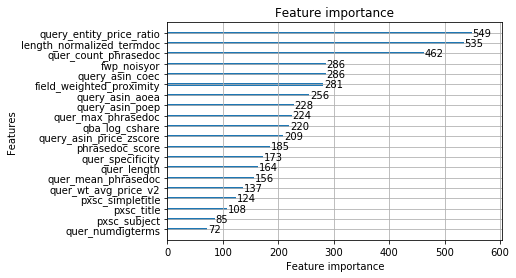

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 16))
ax = lightgbm.plot_importance(final_model)

plt.show()

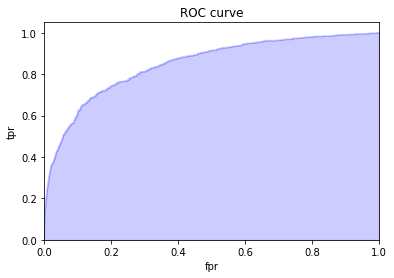

fpr=0.0004 tpr=0.0186 threshold=0.9747
fpr=0.0206 tpr=0.3516 threshold=0.5311
fpr=0.0411 tpr=0.4341 threshold=0.4160
fpr=0.0611 tpr=0.5111 threshold=0.3464
fpr=0.0819 tpr=0.5575 threshold=0.3014
fpr=0.1019 tpr=0.6215 threshold=0.2640
fpr=0.1219 tpr=0.6558 threshold=0.2333
fpr=0.1432 tpr=0.6865 threshold=0.2084
fpr=0.1637 tpr=0.7096 threshold=0.1891
fpr=0.1848 tpr=0.7217 threshold=0.1700


In [16]:
from sklearn.metrics import roc_curve
for mod,X_t in [(final_model, X_test_filtered)]:
    preds = mod.predict_proba(X_t)
    fpr, tpr, thresholds = roc_curve(y_test, preds[:,1], pos_label=1)
    
    plt.step(fpr, tpr, color='b', alpha=0.2, where='post')
    plt.fill_between(fpr, tpr, step='post', alpha=0.2, color='b')

    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('ROC curve')
    plt.show()
    
step = 0.02
last = -step
for i in range(len(fpr)):
    if fpr[i] - last > step and fpr[i] < 0.2:
        last = fpr[i]
        print("fpr=%.4f tpr=%.4f threshold=%.4f" % (fpr[i], tpr[i], thresholds[i]))

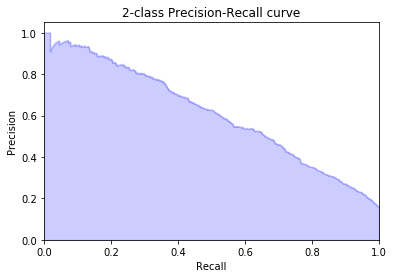

r=0.8701 p=0.30 f1=0.45 threshold=0.0813
r=0.8024 p=0.35 f1=0.49 threshold=0.1150
r=0.7495 p=0.40 f1=0.52 threshold=0.1526
r=0.7124 p=0.45 f1=0.55 threshold=0.1879
r=0.6614 p=0.50 f1=0.57 threshold=0.2272
r=0.5659 p=0.55 f1=0.56 threshold=0.2919
r=0.5269 p=0.60 f1=0.56 threshold=0.3316
r=0.4610 p=0.65 f1=0.54 threshold=0.3946
r=0.3980 p=0.70 f1=0.51 threshold=0.4677
r=0.3618 p=0.75 f1=0.49 threshold=0.5191
average_precision 0.6124735753678242


In [17]:
from itertools import izip
import math
def max_recall_for_precision(data, scores, pos_label, min_pr):
      """Find precision, recall, threshold which is >= min_pr and maximizes recall"""
      if pos_label==0:
          pr, rec, thresh = precision_recall_curve(1 - data, 1 - scores, pos_label=1)
          thresh = 1 - thresh #convert threshold back to P(nondefect) score space
      else:
          pr, rec, thresh = precision_recall_curve(data, scores, pos_label=1)
      values = [(r, p, t) for p, r, t in izip(pr, rec, thresh) if p >= min_pr]
      if len(values) >=1:
          r, p, t = max(values)
          return p, r, t
      return None, None, None


def plot_prcurve(y_test, y_pred):
    plt.figure(figsize=(6, 4))
    precision,recall,threshold = precision_recall_curve(y_test, y_pred)
    plt.step(recall, precision, color='b', alpha=0.1, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve')
    plt.show()

for mod,X_t in [(final_model, X_test_filtered)]:
    preds = mod.predict_proba(X_t)
    plot_prcurve(y_test, preds[:,1])

    for min_pr in range(30, 80, 5):
        min_pr = min_pr / 100.0
        p,r,t = max_recall_for_precision(y_test, preds[:,1], 1, min_pr)
        f1 = 2 * min_pr * r / (min_pr + r)
        print("r=%.4f p=%.2f f1=%.2f threshold=%.4f" % (r, min_pr, f1, t))

    for score in ['average_precision']:
        evaluator = sklearn.metrics.get_scorer(score)
        score_val = evaluator(mod, X_t, y_test)
        print score,score_val

(26889, 20)
(26889,)


/Users/blhuang/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/blhuang/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/blhuang/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/blhuang/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/Users/blhuang/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/blhuang/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/blhuang/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/blhuang/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/Users/blhuang/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/blhuang/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/blhuang/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/blhuang/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/Users/blhuang/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/blhuang/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/blhuang/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/blhuang/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

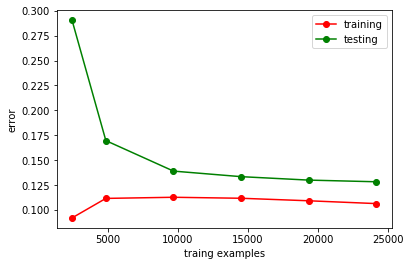

In [18]:
print(X_train_filtered.shape)
print(y_train.shape)
from sklearn.model_selection import learning_curve
lgb_model = LGBMClassifier(boosting_type='gbdt',
                      objective='binary',
                      max_depth=6,
                      learning_rate=0.2,
                      n_estimators=100,
                      min_child_samples=50,
                     silent=False)

train_sizes,train_score,test_score = learning_curve(lgb_model,X_train_filtered.values,y_train.values,train_sizes=[0.1,0.2,0.4,0.6,0.8,1],cv=10,scoring='accuracy')
train_error =  1- np.mean(train_score,axis=1)
test_error = 1- np.mean(test_score,axis=1)
plt.plot(train_sizes,train_error,'o-',color = 'r',label = 'training')
plt.plot(train_sizes,test_error,'o-',color = 'g',label = 'testing')
plt.legend(loc='best')
plt.xlabel('traing examples')
plt.ylabel('error')
plt.show()

In [19]:
filename = "es_dar_model.txt"
import tempfile as tf
import sys
import os
sys.path.append("../")
from PMMLWriter import *

final_model._Booster.save_model(filename)
print 'pmml_file',pmml_file
temp_xml = tf.NamedTemporaryFile()

final_model._Booster.save_model(temp_xml.name)
PMMLWriter(temp_xml.name, pmml_file).write_pmml()


pmml_file es_defect.pmml
Tree=0
num_leaves=31
num_cat=0
split_feature=5 12 7 12 12 19 19 19 1 14 19 0 14 5 19 12 15 12 19 19 10 1 14 19 8 19 12 2 10 4
split_gain=970.90345701238039 353.70489791294563 185.91420376608994 98.678963625860774 145.02960275019097 95.022262638721628 152.64145464868412 70.975810333313348 143.05633987387429 109.28533846755997 70.381638307550929 55.391303765331614 52.376029462939329 44.561848883502535 39.59604458339598 39.396757267500305 31.648073022312374 28.360964043390439 22.487515578819927 20.142260579661411 26.973364388777199 19.75173279188175 20.88561419424866 22.729350381757229 18.06061851136522 17.884337502275457 19.734953703703709 16.628772851925532 15.081367271234285 13.016534088766548
threshold=6.5 3685 5.5 0.5 2316.5 58846127 46.5 5184701 32287.5 20.5 46.5 0.5 4.5 9.5 84.5 4253.5 10194.5 4376.5 24303430 0.5 2.5 33422.5 12.5 49.5 2979.5 5783.5 4068.5 32773.5 2.5 5430.5
decision_type=2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
left_child

Tree=11
num_leaves=31
num_cat=0
split_feature=5 1 12 10 10 19 19 0 5 11 8 7 12 19 13 3 12 13 12 13 10 19 10 8 9 17 2 8 12 16
split_gain=79.203804328712351 20.407972076559815 19.111752920295643 27.133072851606805 18.199349567736618 16.295096595811515 24.203952581028791 20.974026921361066 13.703370325397232 13.488426267114065 18.896702961202976 16.624991954840439 12.228591579815909 11.347121892641196 11.157949711373899 8.4673176917190744 7.4048147038357115 8.9930701125913899 8.683397389263332 7.2258635005043921 6.5356893280503812 6.462698764066964 6.44104879057386 6.0339197770540594 7.7590760932041647 6.9481855830824291 6.006690268567886 5.9438180296159757 5.6829803847263207 5.7336567543224373
threshold=6.5 33559.5 2975 4.5 3.5 5184701 86.5 0.5 0.5 6.5 2258.5 9.5 0.5 345274126 661 32576.5 5506.5 5725.5 5272.5 1301 1.5 1354.5 1.5 298.5 572 897.5 32379.5 2208.5 5506.5 3899
decision_type=2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
left_child=2 4 8 5 9 6 7 -4 14 10 12 -12 -2 

Tree=25
num_leaves=31
num_cat=0
split_feature=11 14 15 2 17 14 17 3 12 7 3 3 17 19 11 2 19 19 7 0 14 10 10 7 7 4 5 19 5 14
split_gain=5.1263783122070512 5.3919781443018548 4.608525840268106 5.7975649146855659 6.0851196821460309 6.9368961925294315 10.310768904950056 9.7282298840568657 5.8837709188548803 5.8532160672580016 6.8443730524603552 5.7132186769739972 8.4124529270088786 10.207850377036722 7.3304379189039359 6.6509773738680087 7.0807842057773991 11.425490253677568 4.8095926559150568 16.496637837057843 14.138226169165488 4.1457705573070598 4.105092874251083 4.9237182856260029 4.0006523092840247 3.5931646119052409 6.5046516295428365 4.2422769538852254 2.1550611746107755 1.9278812956254878
threshold=7.5 1.5 11948.5 33900.5 924.5 380.5 836.5 32885.5 5759.5 9.5 32576.5 34097.5 1089.5 148.5 5.5 33432.5 46.5 97.5 5.5 0.5 11.5 2.5 3.5 9.5 10.5 1039 5.5 41.5 9.5 3.5
decision_type=2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
left_child=2 21 11 4 5 7 -7 -4 -5 -6 -11 15 14 -14

Tree=42
num_leaves=31
num_cat=0
split_feature=4 5 11 5 3 3 17 7 18 16 17 14 12 12 17 11 12 19 7 4 9 1 12 4 15 15 4 4 11 5
split_gain=1.6922217841198368 4.186899736196164 3.6560486009068081 4.2543688226102976 5.2213392143415236 4.9973098896622439 5.9565363760182333 4.7716509262809277 4.6326303195544565 2.756579163581788 6.7326538484200906 10.570376915742534 5.9978431815974149 5.7938518554007628 9.4013683318913834 7.6664988035757204 7.1750653544841869 15.004016102687356 5.9723886771506569 5.5957464315614409 10.18822081733115 5.4378051215189505 5.1664743322316724 5.1502932481517227 7.7678824815374252 16.210436982740994 9.096714398820799 7.6035309454158879 5.2589151895644584 5.1088052346273898
threshold=5640.5 13.5 5.5 11.5 32221.5 32782.5 984.5 9.5 2699.5 5725.5 1183.5 161.5 5804.5 5360.5 1103.5 2.5 5320.5 121.5 6.5 4648.5 5312 34875 5311.5 5430.5 1696 9406 5404 5517 6.5 12.5
decision_type=2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
left_child=9 2 3 4 7 -5 -7 -2 -6 13 23 1

Tree=61
num_leaves=31
num_cat=0
split_feature=16 8 4 8 7 12 12 12 4 16 4 4 8 9 4 12 4 7 5 9 8 4 13 12 7 8 16 7 19 1
split_gain=0.98215413363327586 4.057119452026579 7.3637937532320556 6.8859973059466899 6.8186959138270247 5.5945695851429242 14.496777699592677 10.315765765942519 4.2207616346584675 6.3445684904091557 3.966577501445955 3.6840830744577082 10.373118628804001 11.765654130540032 5.1084664697531679 5.0040197615605067 5.0032299996809702 8.7961383396390023 4.7175555965667151 3.3280853107455117 3.2937574248570853 6.8479836766191209 6.3901242489987657 2.832410149457532 4.0523354478183622 3.6387997894325448 3.0448546173801656 2.8239289796060341 2.5700250119237804 2.2707903733104748
threshold=2298 4057.5 2421 5939 11.5 4422.5 4752.5 3773.5 3067 2794.5 2684 2637.5 3626 4928 2550.5 4239.5 5022.5 10.5 9.5 2208 3666.5 1859.5 5725.5 4694.5 8.5 4829.5 2380 0.5 106.5 32982.5
decision_type=2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
left_child=11 5 23 4 10 7 -7 -2 -5 -10 -4 

Tree=76
num_leaves=31
num_cat=0
split_feature=19 17 3 3 2 1 1 19 8 8 1 4 16 0 15 12 0 19 19 12 13 4 16 12 15 12 18 12 3 19
split_gain=0.87526186681271856 2.825957395060112 2.4991057141357316 5.4306091800982541 5.4239452972640541 4.5751530845365309 2.4548204706621508 1.8573954338100045 4.9159007752842196 5.4335636127499383 4.3525611806644608 4.294169810427559 6.1444995746925972 3.3144389679723476 2.7559319792589978 2.5839666339156127 2.3221216526611332 5.0115280290043636 6.9186774157548463 7.2581529879594999 6.0029819315654036 2.8367606881736176 7.0192612580725005 2.0592695099356706 5.2504709712429261 10.626770677640984 4.966111382190415 3.2566481959787126 5.495045491459809 3.29947762329122
threshold=0.5 858.5 33431.5 33053.5 32857.5 34242.5 33297.5 13.5 3972.5 3559.5 33167.5 2421 2777 0.5 6897 2622 0.5 1354.5 125.5 5320.5 2308 1380 2380 5351.5 10230 3651.5 1933.5 5433.5 32785.5 29.5
decision_type=2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
left_child=1 2 3 4 6 -4 -1 8 9

Tree=94
num_leaves=20
num_cat=0
split_feature=15 15 4 8 6 15 11 17 1 1 15 17 11 8 18 18 1 3 19
split_gain=0.64591109225137755 3.5068598592038032 4.7054554315073593 3.817776993591556 2.4102477917959266 2.3682841975774633 5.3902074782738794 1.9237982661838637 5.2731121555613338 5.340209093414491 3.4539592810758677 5.3133877863965751 2.8816275576230566 1.5007717823430973 1.1156999753186603 1.4340723085883946 0.97045811320749753 4.2585548578709069 4.2393433911392888
threshold=7308.5 8172.5 5136 1845 152.5 6897 3.5 828.5 34242.5 33643.5 11646 1067.5 3.5 5827.5 7602 5136.5 32774.5 32451.5 27.5
decision_type=2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
left_child=5 2 3 -2 7 14 -7 8 9 -3 11 -9 -12 -5 15 16 17 -1 -18
right_child=1 4 -4 13 -6 6 -8 10 -10 -11 12 -13 -14 -15 -16 -17 18 -19 -20
leaf_parent=17 3 9 2 13 4 6 6 11 8 9 12 11 12 13 14 15 18 17 18
leaf_value=0.00064485908822481213 -0.0011995607467524701 -0.020934395645664045 0.080153557563674316 -0.23059238436103296 -0.10658804218282043 0.233865

Tree=109
num_leaves=24
num_cat=0
split_feature=9 9 8 4 8 0 8 19 14 14 19 3 14 11 5 10 0 11 9 0 11 19 10
split_gain=0.39929743179433241 4.6190653696993005 3.9020959860059072 2.9987266013852083 1.9215366586511435 3.819755953850255 1.9939806061948049 1.6748058827086958 1.5194363826945383 3.052725766024377 5.6379230220762633 2.7606109929954608 2.3130020229097377 1.5077668518407472 4.0103153165372234 2.1117762366303774 4.1500234088279697 2.4226573941063174 2.3063747584257364 3.7295990919769282 2.2776370260817389 1.4490556616902377 0.99746089590156295
threshold=2670 2390 5049.5 4029 4404.5 0.5 4035.5 101.5 3897 544.5 264.5 32512.5 199.5 8.5 6.5 4.5 0.5 4.5 2993 0.5 6.5 21.5 2.5
decision_type=2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
left_child=1 3 7 8 5 6 -2 21 9 12 -11 -10 -1 15 22 18 -17 -18 19 -6 -20 -3 -15
right_child=4 2 -4 -5 13 -7 -8 -9 11 10 -12 -13 -14 14 -16 16 17 -19 20 -21 -22 -23 -24
leaf_parent=12 6 21 2 3 19 5 6 7 11 10 10 11 12 22 14 16 17 17 20 19 20 21 22
leaf_value=0.0

Tree=125
num_leaves=19
num_cat=0
split_feature=2 3 4 3 19 3 19 2 10 19 3 3 19 7 1 3 1 3
split_gain=0.37871834398931803 3.2751999930357445 1.8038352224639989 4.9425324298807434 1.8330307062396785 2.2014378692633567 2.5124015361759864 1.5743266782328553 2.749698158529724 2.0140103608904028 0.88095573520913406 1.9090308958818407 6.8508846044514522 4.4918155001364326 2.6105911955061973 1.3628415788518173 1.8087675379157848 1.518644845533105
threshold=33042.5 33058.5 5559 33907.5 210.5 33151.5 169.5 32978.5 2.5 82.5 33921.5 33469.5 77.5 11.5 33888.5 33339.5 33920 33252.5
decision_type=2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
left_child=7 -2 4 -4 5 -3 -7 10 9 -9 11 15 13 -13 -14 17 -17 -1
right_child=1 2 3 -5 -6 6 -8 8 -10 -11 -12 12 14 -15 -16 16 -18 -19
leaf_parent=17 1 5 3 3 4 6 6 9 8 9 10 13 14 13 14 16 16 17
leaf_value=-0.00094892073378969883 0.15341730342797621 -0.12220935398280892 0.18389767123624445 -0.064585042919806823 -0.11269195912547102 0.00059968058102912965 0.14211865723297565 -0.0

Tree=142
num_leaves=27
num_cat=0
split_feature=12 1 1 5 15 14 1 6 2 6 18 6 4 17 12 14 19 14 18 15 14 7 17 5 11 19
split_gain=0.38511386875659304 1.7435104847647922 3.6165031008061748 2.0000158048757926 1.9667520927153468 1.9992689373038961 1.8860068841259388 1.736242779011431 3.0769270050455289 2.4846228458372281 1.2692756049156635 3.82439876592845 3.0901217304237165 2.7830734743108083 2.4736207162628787 1.3145611710175933 4.4923834696416449 4.1220733238773395 3.3431510328301646 3.1582532393324301 2.5454529852216794 8.6744185091218604 5.2126347631195067 1.231169730522323 1.1379013067491426 1.3874922184192342
threshold=4347.5 33725.5 33631.5 14.5 5051.5 62.5 33531.5 7.5 32687.5 3.5 2699.5 0.5 4222.5 958.5 5686.5 95.5 544 101.5 1827 13842.5 50.5 10.5 800.5 11.5 5.5 70.5
decision_type=2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
left_child=1 2 6 4 24 -6 7 9 -9 -1 15 -12 -13 -14 -15 19 17 -17 -19 20 22 -22 -2 -18 25 -3
right_child=10 3 -4 -5 5 -7 -8 8 -10 -11 11 12 13 14 -16 16 23 1

Tree=160
num_leaves=8
num_cat=0
split_feature=10 18 2 18 18 18 7
split_gain=0.36635278711167196 0.34683390479514054 1.6187206037018689 0.5020886194023052 0.73045955638547255 0.59903999442319433 0.4598050914750586
threshold=0.5 7716.5 32560.5 5136.5 3902.5 3262 12.5
decision_type=2 2 2 2 2 2 2
left_child=-1 3 -3 4 5 6 -2
right_child=1 2 -4 -5 -6 -7 -8
leaf_parent=0 6 2 2 3 4 5 6
leaf_value=0.046599311170954082 -0.00092487845531063508 0.03098010244950386 -0.11157932474128612 0.046244506681355067 -0.07060651578595889 0.067720087467166609 0.013474259207605192
leaf_count=65 24511 91 265 144 122 106 1585
internal_value=0 -0.0019637468499072021 -0.16566508454625442 -0.0010927436906077916 -0.0019859620456123238 -0.0011226793975629486 -0.0018560424727713327
internal_count=26889 26824 356 26468 26324 26202 26096
shrinkage=0.2
Tree=161
num_leaves=8
num_cat=0
split_feature=15 15 15 1 15 6 14
split_gain=0.32381034892546839 1.1085788661067468 1.0370557484599485 0.73395875179644465 0.9110842046276266

Tree=178
num_leaves=28
num_cat=0
split_feature=11 5 10 4 4 11 8 16 12 5 5 14 16 14 5 10 9 5 6 2 6 5 12 12 2 1 5
split_gain=0.27497672460096412 2.6336585589501609 3.117979616564448 5.110998398995692 8.0809562003789708 3.4178024591986214 3.0664095898127783 4.3361291038694176 2.9180801529794596 4.6348553574690854 2.7077769369761775 2.3819972201109172 2.233350120527279 2.1278567545430116 2.3153130578992513 2.8681730303370756 2.6723936265271626 1.3648648173582565 0.40190041124836312 1.8633265427605363 0.9952185438395339 0.46105314165404482 2.073715686639829 1.9102208931005524 1.8935993879552377 1.3330035818408508 0.87427010111135872
threshold=6.5 8.5 2.5 1350.5 2070 8.5 3287.5 2057 5506.5 12.5 5.5 1.5 4571.5 26.5 10.5 2.5 5725.5 3.5 196 32602.5 143 12.5 5922.5 5672.5 32914.5 34938.5 11.5
decision_type=2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
left_child=18 2 6 5 -5 17 10 -8 13 -10 -2 -9 -6 14 15 -3 -16 -4 20 -20 21 25 23 -23 -24 26 -1
right_child=1 8 3 4 12 -7 7 11 9 -11 -12 -13

Tree=195
num_leaves=23
num_cat=0
split_feature=6 19 12 1 2 12 2 7 12 3 1 12 17 1 17 12 2 17 19 17 19 2
split_gain=0.28025531939275844 2.065037332974712 1.6354162436430999 1.4904888616405965 2.4843248362978523 1.8519907567678109 1.0045447571495567 0.81127154340046137 0.54486893635624556 1.8504659644539054 3.0309316023013544 0.50335644357073206 3.9048479757238783 1.7349631432792476 0.65047707821824963 2.0444282977548927 3.0779041916337326 1.8106108340429525 3.3999182538325465 2.3281523925188794 0.44098696584960917 0.34593411304644439
threshold=38.5 159.5 5912.5 34251.5 32263.5 5759.5 32647.5 11.5 5958.5 32866.5 32684.5 5922.5 1016.5 33069.5 1156.5 5798.5 32857.5 1085.5 119.5 1076.5 97.5 32694.5
decision_type=2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
left_child=8 2 3 4 7 -6 -3 -2 11 10 -10 14 13 -13 17 16 -16 19 -19 -1 -5 -17
right_child=1 6 -4 20 5 -7 -8 -9 9 -11 -12 12 -14 -15 15 21 -18 18 -20 -21 -22 -23
leaf_parent=19 7 6 2 20 5 5 6 7 10 9 10 13 12 13 16 21 16 18 18 19 20 21
leaf_va